# MNIST Fashion Dataset Classifier
### John Guerrerio

This code sample is my first expirience with computer vision.  I aimed to learn the basics of CNNs and image processing.  To do so, I built a CNN classifier for the MNIST fashion dataset.

Note: The MNIST fashion dataset is too large to upload to GitHub.  Please download it from this link: https://www.kaggle.com/datasets/zalando-research/fashionmnist

## CNN Basic Explination

A CNN, or Convolutional Neural Network, is a type of deep learning algorithm typically used for image recognition and classification tasks.  A CNN typically consists of the following elements:

- Convolution Layers: These are the core building blocks of a CNN.  Convolution layers apply convolution operations to thier input.  A convolution operation slides a filter matrix, or kernel, over the input data and computing dot products to produce feature maps. These feature maps capture different aspects of the input, such as edges, textures, or patterns.  Kernels contain learnable parameters that are updated during training.
- Batch Normalization Layers: These layers perform normlization of the feature maps generated by convolutional layers during training.  For each feature dimension, Batch Normalization normalizes the activations across the mini-batch by subtracting the mean and dividing by the standard deviation.  After normalization, the activations are scaled a learnable parameter (gamma) and shifted by another learnable parameter (beta).  The purpose of these layers is to address internal covariate shift, or the change in the distribution of network activations as the parameters of the preceding layers change during training. This phenomenon can slow down training and make it more difficult to optimize the network.
- Pooling Layers: Pooling layers downsample the feature maps generated by the convolutional layers by combining the information from multiple feature map matrix entries into a single entry.  One common type of pooling is maxPooling, which slides a small matrix over the feature map and samples only the maximum value in the smaller matrix.  Pooling layers help reduce overfitting and allow for later layers in the CNN to learn more abstract features from the input image (as opposed to more surface-level feautres like object boundaries).

Together, these elements allow us to build CNNs, which generate representations of the input image.  These representations are then flattened and passed to fully connected layers, which use them to make a classification decision.

## Citations
I learned about CNNs and how to code them in PyTorch from the following resources:
- https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
- https://machinelearningmastery.com/building-a-convolutional-neural-network-in-pytorch/

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# Hyperparameters
LEARNING_RATE = 0.001
BATCH_SIZE = 128
DROPOUT = 0.2
EPOCHS = 24
IMAGE_SIZE = 28

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
train = pd.read_csv("fashion-mnist_train.csv")
test = pd.read_csv("fashion-mnist_test.csv")

In [6]:
print(len(train))
print(len(test))

60000
10000


In [7]:
# Custom dataset class for the MNIST dataset
class FashionDataset(Dataset):
    def __init__(self, data, transform = None):
        self.fashion_MNIST = list(data.values)
        self.transform = transform

        label = []
        image = []

        for i in self.fashion_MNIST:
            label.append(i[0])
            example = np.asarray(i[1:])

            # Check for corrupted images and ignore them
            if np.isnan(example).any() or np.isinf(example).any():
              print("Image data contains NaN or infinite values.")
            else:
              image.append(i[1:])

        self.labels = np.asarray(label).astype('uint8')

        # Dimension of Images = 28 * 28 * 1  height = 28, width = 28, and color_channels = 1 (black/white images)
        self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype('uint8')

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)

In this cell, we load and transform our dataset.  Transforms are a valuable way of cleaning image data and improving performance.  For this simple task, we define the following transforms:
- transforms.ToTensor: This converts the numpy arrays representing our images to Pytorch tensors and normalizes our data to values in the range [0.0, 1.0].  This normalization is important for several resons.  Firstly, it helps stabilize the training process.  Large values like 255 can lead to exploding gradients during training, which can hinder convergance.  By re-scaling data, we avoid this problem.  In a similar vein, normalizing values also helps the optimization algorithm (Adam in this case) more effectively naivgate the loss landscape and coverge more quickly.  Finally, normilzation helps the model generalize to unseen data by ensuring the training set and the unseen set have a consistent distribution.  
- transforms.Resize: This transform resizes the image to the desired dimensions.  As all images in MNIST fashion dataset already have consistent dimensions (28 x 28), this transform is unnecesary.  However, its good practice to include it in case we have a dataset with differently sized images.

In [8]:
trainSet = FashionDataset(train, transform=transforms.Compose([
                                                    transforms.ToTensor(),
                                                    transforms.Resize(IMAGE_SIZE)
                                                    ]))
testSet = FashionDataset(test, transform=transforms.Compose([transforms.ToTensor()]))

In [9]:
print(len(trainSet))
print(len(testSet))

60000
10000


In [10]:
trainLoader = DataLoader(trainSet, batch_size=BATCH_SIZE)
testLoader = DataLoader(trainSet, batch_size=BATCH_SIZE)

In [11]:
# function to make labels interpretable
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat",
                 5: "Sandal",
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }

    if type(label) == torch.Tensor:
      input = label.item()
    else:
      input = label

    return output_mapping[input]

In [12]:
# sanity check for dimensions - should be batch size x color channels x image size x image size
next(iter(trainLoader))[0].size()

torch.Size([128, 1, 28, 28])

Pullover


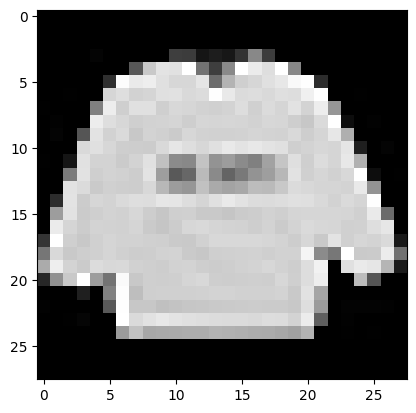

In [13]:
# sanity check to make sure images look correct
image, label = next(iter(trainSet))
plt.imshow(image.squeeze(), cmap="gray")
print(output_label(label))

The below cell defines our model architecture for the classification task.  The convolution blocks of our model create a represention of the image, and then the linear layers use that representation to make a classification decision.

Within the convolutional part of the model, we want the model to learn hierarchcally.  This means that lower layers (the first colvolution block) learns surface level features like object borders, and the higher layers (the second convolution block) learn more abstract features.  This is important in creating robust representations of our input data that allow our classifier to perform well.

The comments over each line in the model architecture were notes I made as I was learning the concepts; I've left them in because they show my thought process and how I learn new things.  More detailed explinations of key CNN concepts can also be found in these comments.

In [14]:
class FashionCNN(nn.Module):

    def __init__(self):
        super(FashionCNN, self).__init__()

        # convolution block
        # tensors are 4D here - (batch size, channel dimension, height, width)
        self.block1 = nn.Sequential(

            # convolution layer
            # one in-channel because the image is black and white - if it were colored we would have three channels (one for each RGB)
            # 32 out channels - each channel is as sosiated with a differnet kernel
            # Kernel is 3x3
            # stride default is 1 - kernel moves pixel by pixel (along height and width dimensions)
            # padding is 1 - ensures the dimensionality of the output feature map is the same as the input image
            # this preserves spatial information in the feature maps - helps learn more abstract representations in deeper layers
            # features learned in CNNs are hierarchical - earlier layers learn things edges and textures
            # keeping the spatial dimensionality the same helps with that
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),

            # standard normalization the resulting channels
            # improves training stability and performance, helps the loss converge
            # scaling factor and translation factor learnable by default
            # applied to the 32 channels output from the convolution layer
            nn.BatchNorm2d(32),

            # activation function
            nn.ReLU(),

            # max pooling to downsample dimensionality of feature maps
            # helps find most improtant features while discarding the rest - helps with robustness of learned representations
            # makes the network less sensitive to small translations in input data
            # pool over 2x2 window
            # stride is 2 - window slides two pixels at a time
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.block2 = nn.Sequential(
            # same kernel size, but we have more output channels this time - increases depth
            # padding defaults to 0 - decreases spatial dimensionality (helpful for learning more abstract features and global context of the image as each unit captures more from the image)
            # increasing channels allows the model to learn and represent more features in the data
            # this layer builds upon the first layer to learn more abstract features
            # more channels allows the model to be more adaptable
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),

            # standard normalization again
            nn.BatchNorm2d(64),

            # activation function
            nn.ReLU(),

            # max pooling again - dimensionality reduction before the fully connected layers
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # linear layer dimensionality decreasing each layer - helps extract the most important features
        # captures hierarchical features

        # we have 64 channels (depth), and the spatial dimensionality of our images is 6x6 at this point
        self.linear1 = nn.Linear(64*6*6, 600)

        # helps avoid overfitting and improves generalization
        # prevents neurons from relying too heavily on specific features and forces neurons to learn independent/redundent features
        self.drop = nn.Dropout2d(p=DROPOUT)

        # hidden linear layer
        self.linear2 = nn.Linear(600, 120)

        # classification layer
        self.head = nn.Linear(120, 10)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)

        # flattens the output of the convolution blocks so we can use linear layers
        # dimensionality changes from (batch_size, channels, height, width) to (batch_size, channels * height * width)
        x = x.view(x.size(0), -1)


        x = self.linear1(x)

        x = self.drop(x)

        x = self.linear2(x)
        logits = self.head(x)

        return logits

In [15]:
classifier = FashionCNN()
classifier.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=LEARNING_RATE)

print(classifier)

FashionCNN(
  (block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.2, inplace=False)
  (linear2): Linear(in_features=600, out_features=120, bias=True)
  (head): Linear(in_features=120, out_features=10, bias=True)
)


In [16]:
history = {}
history["epoch"]=[]
history["train_loss"]=[]
history["train_accuracy"]=[]


# train the classifier - fairly standard training loop
for e in range(EPOCHS):

    classifier.train() # activated dropout

    train_loss = 0.0
    train_accuracy = []

    for images, labels in tqdm(trainLoader):
      images = images.to(device)
      labels = labels.to(device)

      prediction = classifier(images)
      loss = criterion(prediction, labels)

      train_loss += loss.item()

      # determine the optimal direction to increment parameters
      loss.backward()

      # update parameters
      optimizer.step()

      # zero the gradient so we don't accumulate optimizer steps
      optimizer.zero_grad()

      train_loss += loss.item()

      prediction_index = prediction.argmax(axis=1)
      accuracy = (prediction_index==labels).tolist()
      train_accuracy += accuracy

    train_accuracy = (sum(train_accuracy) / len(train_accuracy))

    # keep a record of our training results
    history["epoch"].append(e+1)
    history["train_loss"].append(train_loss / len(trainLoader))
    history["train_accuracy"].append(train_accuracy)

    # output results
    print(f'Epoch {e+1}')
    print(f'\t\t Training Loss: {train_loss / len(trainLoader) :10.3f}')
    print(f'\t\t Training Accuracy: {train_accuracy :10.3%}')

  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
100%|██████████| 469/469 [00:06<00:00, 74.40it/s] 


Epoch 1
		 Training Loss:      0.867
		 Training Accuracy:    84.692%


100%|██████████| 469/469 [00:04<00:00, 109.62it/s]


Epoch 2
		 Training Loss:      0.589
		 Training Accuracy:    89.488%


100%|██████████| 469/469 [00:05<00:00, 92.61it/s] 


Epoch 3
		 Training Loss:      0.511
		 Training Accuracy:    90.897%


100%|██████████| 469/469 [00:04<00:00, 109.87it/s]


Epoch 4
		 Training Loss:      0.462
		 Training Accuracy:    91.790%


100%|██████████| 469/469 [00:04<00:00, 111.25it/s]


Epoch 5
		 Training Loss:      0.428
		 Training Accuracy:    92.345%


100%|██████████| 469/469 [00:04<00:00, 94.40it/s] 


Epoch 6
		 Training Loss:      0.396
		 Training Accuracy:    92.857%


100%|██████████| 469/469 [00:04<00:00, 113.08it/s]


Epoch 7
		 Training Loss:      0.376
		 Training Accuracy:    93.305%


100%|██████████| 469/469 [00:04<00:00, 109.14it/s]


Epoch 8
		 Training Loss:      0.356
		 Training Accuracy:    93.638%


100%|██████████| 469/469 [00:04<00:00, 95.33it/s] 


Epoch 9
		 Training Loss:      0.329
		 Training Accuracy:    94.077%


100%|██████████| 469/469 [00:04<00:00, 109.91it/s]


Epoch 10
		 Training Loss:      0.311
		 Training Accuracy:    94.498%


100%|██████████| 469/469 [00:04<00:00, 103.44it/s]


Epoch 11
		 Training Loss:      0.294
		 Training Accuracy:    94.828%


100%|██████████| 469/469 [00:04<00:00, 100.24it/s]


Epoch 12
		 Training Loss:      0.278
		 Training Accuracy:    95.055%


100%|██████████| 469/469 [00:04<00:00, 111.43it/s]


Epoch 13
		 Training Loss:      0.265
		 Training Accuracy:    95.278%


100%|██████████| 469/469 [00:04<00:00, 100.11it/s]


Epoch 14
		 Training Loss:      0.253
		 Training Accuracy:    95.538%


100%|██████████| 469/469 [00:04<00:00, 103.68it/s]


Epoch 15
		 Training Loss:      0.238
		 Training Accuracy:    95.797%


100%|██████████| 469/469 [00:04<00:00, 110.50it/s]


Epoch 16
		 Training Loss:      0.222
		 Training Accuracy:    96.038%


100%|██████████| 469/469 [00:04<00:00, 94.10it/s]


Epoch 17
		 Training Loss:      0.204
		 Training Accuracy:    96.418%


100%|██████████| 469/469 [00:04<00:00, 108.64it/s]


Epoch 18
		 Training Loss:      0.198
		 Training Accuracy:    96.458%


100%|██████████| 469/469 [00:04<00:00, 111.04it/s]


Epoch 19
		 Training Loss:      0.200
		 Training Accuracy:    96.435%


100%|██████████| 469/469 [00:04<00:00, 94.93it/s]


Epoch 20
		 Training Loss:      0.184
		 Training Accuracy:    96.708%


100%|██████████| 469/469 [00:04<00:00, 110.95it/s]


Epoch 21
		 Training Loss:      0.173
		 Training Accuracy:    96.880%


100%|██████████| 469/469 [00:04<00:00, 111.03it/s]


Epoch 22
		 Training Loss:      0.177
		 Training Accuracy:    96.760%


100%|██████████| 469/469 [00:05<00:00, 93.25it/s] 


Epoch 23
		 Training Loss:      0.167
		 Training Accuracy:    96.985%


100%|██████████| 469/469 [00:04<00:00, 110.05it/s]

Epoch 24
		 Training Loss:      0.175
		 Training Accuracy:    96.753%


The following cell plots our training loss and accuracy.  The training loss appeared to converge around 0.17 and the training accuracy appeared to converge around 0.97 (see the graphs below). These graphs indicate that we stopped training at the appropriate time with acceptable performance for our toy example.  However, for a real classifier, some other factors I would want to consider would be:
- Validation accuracy/loss: For this toy example, I was more focused on learning CNN/image processing conepts.  However, validation accuracy/loss is an improtant metric to determine if our model has overfitted its training data.
- Reproducibility: I would trian the model multiple times to ensure it converged consistently.  If convergance varied significantly between runs, this would be indicative of instability in training.  If this were the case, some potential mitigants would be early stopping (stopping training when performance on the validation set begins to degrade), expirimenting with the learning rate and other hyperparameters, and gradient clipping (limiting the magnitude of gradients during training to avoid "exploding" gradients).

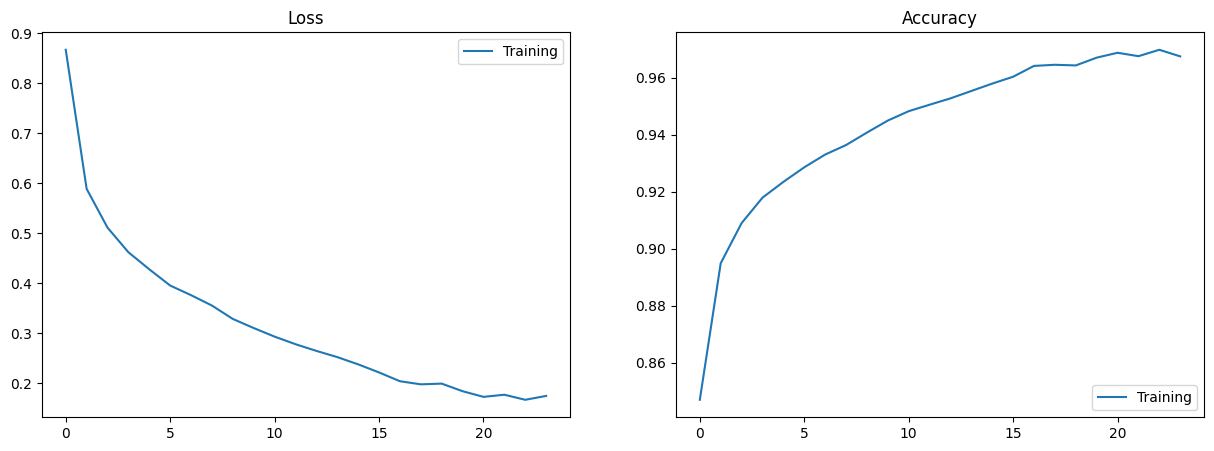

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set(title='Loss')
ax[0].plot(history['train_loss'], label='Training')
ax[0].legend(loc="upper right")

ax[1].set(title='Accuracy')
ax[1].plot(history['train_accuracy'], label='Training')
ax[1].legend(loc="lower right")

In [18]:
allPredictions = []
groundTruth = []

# evalaute model on the test set
classifier.eval()
with torch.no_grad():
    for images, labels in testLoader:
        images = images.to(device)
        labels = labels.to(device)

        prediction = classifier(images)
        prediction_index = prediction.argmax(axis=1)

        prediction_index = prediction_index.tolist()
        labels = labels.tolist()

        allPredictions += prediction_index
        groundTruth += labels

In [19]:
print(classification_report(groundTruth, allPredictions))
# we get an overall accuracy of 0.96, which is 0.03 below the state of the art, but decent for a relatively shallow CNN

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      6000
           1       1.00      1.00      1.00      6000
           2       0.96      0.93      0.95      6000
           3       0.96      0.98      0.97      6000
           4       0.89      0.98      0.93      6000
           5       1.00      0.99      1.00      6000
           6       0.94      0.85      0.89      6000
           7       1.00      0.96      0.98      6000
           8       0.99      1.00      1.00      6000
           9       0.96      1.00      0.98      6000

    accuracy                           0.96     60000
   macro avg       0.96      0.96      0.96     60000
weighted avg       0.96      0.96      0.96     60000



In [20]:
print(confusion_matrix(groundTruth, allPredictions))

[[5656    4   57   46   19    0  203    0   14    1]
 [   0 5979    0   16    3    0    1    0    1    0]
 [  16    1 5591   30  269    0   86    0    6    1]
 [  38    3    0 5905   36    0   15    0    2    1]
 [   1    1   44   53 5886    0   11    0    3    1]
 [   0    0    0    0    0 5966    0    3    1   30]
 [ 265    6  110  118  378    0 5103    1   17    2]
 [   0    0    0    0    0   15    0 5763    0  222]
 [   1    0    0    0    0    0    0    0 5999    0]
 [   0    0    0    0    0    0    0    2    1 5997]]
